In [18]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import librosa

In [19]:
path='../../data/train/asbfly/XC134896.ogg'

In [20]:
audio = AudioSegment.from_ogg(path)

print(audio)
print(type(audio))

# audio duration
duration_seconds=len(audio)/1000.0

print(duration_seconds)
# print(duration_seconds/60) # minutes

# sampling rate
sr=audio.frame_rate

print(sr)

# the num of channels
print(audio.channels)

# bit depth
bit_depth=audio.sample_width * 8

print(bit_depth)

<class 'pydub.audio_segment.AudioSegment'>
27.35
32000
1
32


In [21]:
samples = np.array(audio.get_array_of_samples())

In [22]:
samples.shape

(875207,)

In [23]:
# setup target sampling rate
target_sample_rate = 22050

# re sampling
samples = librosa.resample(y=samples.astype(float), orig_sr=audio.frame_rate, target_sr=target_sample_rate)


In [24]:
samples.shape

(603073,)

In [25]:
# Generate Mel spectrum
mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=target_sample_rate, n_fft=2048, hop_length=512, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=np.max)


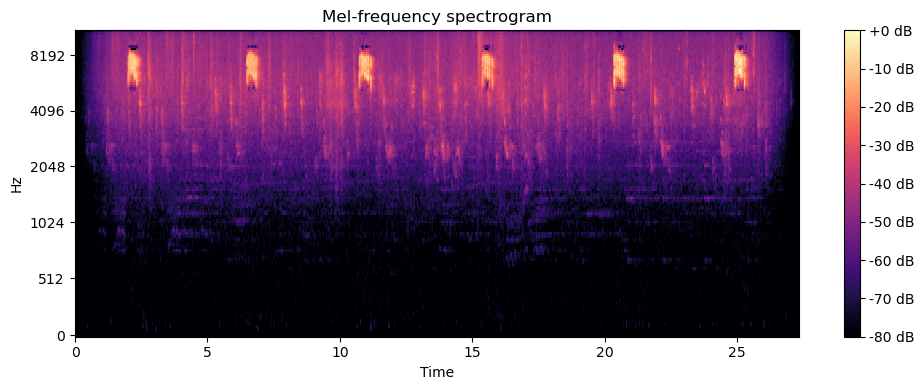

In [26]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=target_sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


Mel spectrum is a special type of spectrogram that not only shows the frequency components of a signal, but also uses the Mel scale to be closer to human auditory perception. The Mel scale is a nonlinear frequency scale that mimics the sensitivity of the human ear to different frequencies, making low frequencies have higher resolution and high frequencies have lower resolution.

Features: Mel spectrum emphasizes the frequency range that is more sensitive to human hearing by mapping the output of the FFT to the Mel scale.
Use scenarios: Mel spectrum is often used in speech recognition, music analysis, and any occasions where it is necessary to simulate human ear perception.


## Data conversion using torchaudio

https://pytorch.org/audio/stable/transforms.html#torchaudio-transforms

In [27]:
import torchaudio

In [28]:
audio, sample_rate = torchaudio.load(path)

print(audio.shape)

# n_mels represents the number of filters, 128 is mentioned in the SED paper
# Using more Mel filters can improve the frequency resolution of the spectrum, so that the spectrum can more finely represent the frequency content of the audio signal.
# This is especially important for tasks such as sound event detection (SED) and automatic speech recognition (ASR), because these tasks rely on accurately capturing the subtle differences in audio. 
# Choosing the right n_mels value is crucial to optimizing system performance and processing specific types of audio data.
mel_spectrogram=torchaudio.transforms.MelSpectrogram(sample_rate=sr,n_fft=2048,hop_length=1024,n_mels=128,f_min=0,f_max=16000)

mel_spec=mel_spectrogram(audio)

torch.Size([1, 875207])


In [29]:
mel_spec.shape 
# (channels,mels,time)

torch.Size([1, 128, 855])

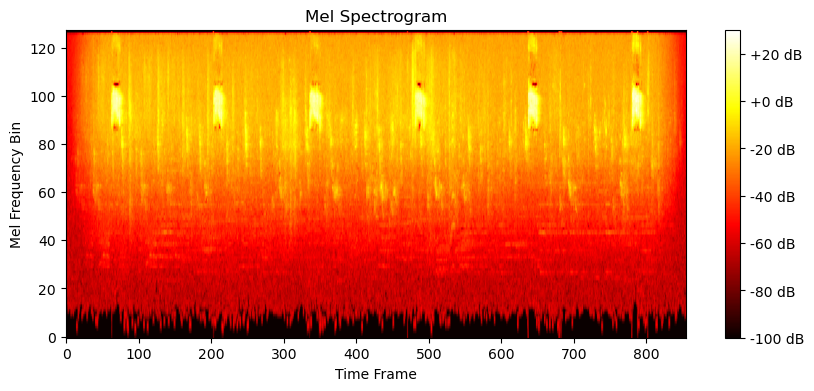

In [30]:
# Convert to decibel scale for better visualization
mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)

# draw
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db[0].numpy(), cmap='hot', origin='lower', aspect='auto')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')
plt.show()

According to the recommendation of the SED article,

A recommended feature representation for a basic SED system is 40 log mel energies calculated in 40 ms windows, which provides a detailed enough, but not too high-dimensional representation.

The following is the implementation for a single audio data

In [31]:
audio, sample_rate = torchaudio.load(path)

print(audio)
print(type(audio))
print(audio.shape)

# Determine window size and frame shift
window_size = 0.04  # 40 ms
hop_size = 0.02    # 20 ms，Usually half the window size
n_fft = int(window_size * sr)  # Convert window size to number of sampling points
hop_length = int(hop_size * sr)  # Convert frame shift to sample count


# Calculate Mel spectrum
n_mels = 40  # Number of Mel filters

mel_spectrogram=torchaudio.transforms.MelSpectrogram(sample_rate=sr,n_fft=n_fft,hop_length=hop_length,n_mels=n_mels,f_min=0,f_max=16000)
mel_spec=mel_spectrogram(audio)

tensor([[ 1.3738e-06,  9.2571e-07, -2.7169e-06,  ...,  6.2166e-06,
         -1.4831e-06, -3.4762e-06]])
<class 'torch.Tensor'>
torch.Size([1, 875207])


In [32]:
mel_spec.shape 
# (channels,mels,time)

torch.Size([1, 40, 1368])

torch.Size([1, 40, 1368])


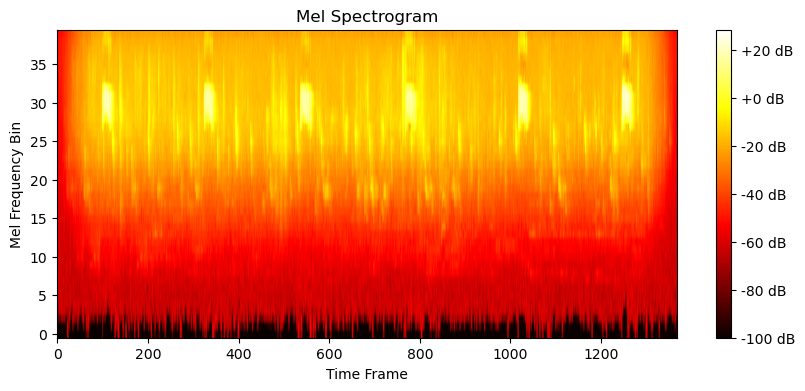

In [33]:
mel_spectrogram_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
print(mel_spectrogram_db.shape)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db[0].numpy(), cmap='hot', origin='lower', aspect='auto')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')
plt.show()